In [48]:
import numpy as np
import matplotlib as mpl 
from matplotlib import pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [10]:
def notEmpty(s):
    return s != ''

In [23]:
mpl.rcParams["font.sans-serif"] = ["simHei"]
mpl.rcParams["axes.unicode_minus"] = False
# 拦截异常
warnings.filterwarnings(action="ignore",category=ConvergenceWarning)

In [37]:
names = ['CRIM','ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
path = "datas/boston_housing.data"
df = pd.read_csv(path, header=None)
data = np.empty((len(fd), 14))
# 将字符串分割并转化成浮点型
for i,d in enumerate(df.values):
    d = map(float,filter(notEmpty,d[0].split(" ")))
    data[i] = list(d)
x,y = np.split(data,(13,),axis=1)
y = y.ravel()
print("样本数据量：%d,特征个数：%d" % x.shape)
print("target样本数据量：%d"%y.shape[0])

样本数据量：506,特征个数：13
target样本数据量：506


In [38]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(x,y,train_size=0.8,random_state=14)
x_train,x_test,y_train,y_test = x_train1,x_test1,y_train1,y_test1
print("训练数据集样本数目：%d,测试数据集样本数目：%d" % (x_train.shape[0],x_test.shape[0]))

训练数据集样本数目：404,测试数据集样本数目：102


In [39]:
#标准化
ss = MinMaxScaler()

x_train = ss.fit_transform(x_train, y_train)
x_test = ss.transform(x_test)

print ("原始数据各个特征属性的调整最小值:",ss.min_)
print ("原始数据各个特征属性的缩放数据值:",ss.scale_)

原始数据各个特征属性的调整最小值: [-7.10352762e-05  0.00000000e+00 -1.68621701e-02  0.00000000e+00
 -7.92181070e-01 -6.82314620e-01 -2.98661174e-02 -1.02719857e-01
 -4.34782609e-02 -3.56870229e-01 -1.34042553e+00 -6.38977636e-03
 -4.90780142e-02]
原始数据各个特征属性的缩放数据值: [1.12397589e-02 1.00000000e-02 3.66568915e-02 1.00000000e+00
 2.05761317e+00 1.91607588e-01 1.02986612e-02 9.09347180e-02
 4.34782609e-02 1.90839695e-03 1.06382979e-01 2.53562554e-03
 2.83687943e-02]


In [41]:
# 构建模型（回归树）
model = DecisionTreeRegressor(criterion="mae",max_depth=7)
# 模型训练
model.fit(x_train,y_train)
# 模型预测
y_test_hat = model.predict(x_test)

In [42]:
# 评估模型
score = model.score(x_test,y_test)
print("Score:",score)

Score: 0.8055884386035101


In [45]:
# 构建线性回归
lr = LinearRegression()
# 模型训练
lr.fit(x_train,y_train)
# 预测
lr_y_test_hat = lr.predict(x_test)
lr_score = lr.score(x_test,y_test)
print("lr:",lr_score)

# 构建lasso回归
lasso = LassoCV(alphas = np.logspace(-3,1,20))
lasso.fit(x_train,y_train)
lasso_y_test_hat = lasso.predict(x_test)
lasso_score = lasso.score(x_test,y_test)
print("lasso:",lasso_score)

# 构建岭回归
ridge = RidgeCV(alphas=np.logspace(-3,1,20))
ridge.fit(x_train, y_train)
ridge_y_test_hat = ridge.predict(x_test)
ridge_score = ridge.score(x_test, y_test)
print ("ridge:", ridge_score)

lr: 0.6177265992293739
lasso: 0.617887746021268
ridge: 0.6209247731652219


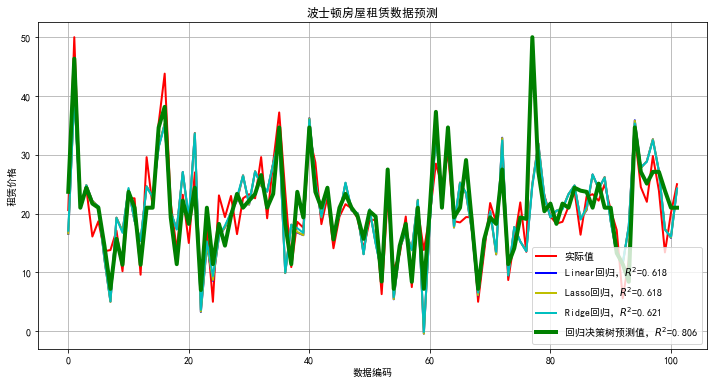

In [49]:
## 7. 画图
plt.figure(figsize=(12,6), facecolor='w')
ln_x_test = range(len(x_test))

plt.plot(ln_x_test, y_test, 'r-', lw=2, label='实际值')
plt.plot(ln_x_test, lr_y_test_hat, 'b-', lw=2, label='Linear回归，$R^2$=%.3f' % lr_score)
plt.plot(ln_x_test, lasso_y_test_hat, 'y-', lw=2, label='Lasso回归，$R^2$=%.3f' % lasso_score)
plt.plot(ln_x_test, ridge_y_test_hat, 'c-', lw=2, label='Ridge回归，$R^2$=%.3f' % ridge_score)
plt.plot(ln_x_test, y_test_hat, 'g-', lw=4, label='回归决策树预测值，$R^2$=%.3f' % score)
plt.xlabel('数据编码')
plt.ylabel('租赁价格')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.title('波士顿房屋租赁数据预测')
plt.show()

In [53]:
# 参数优化
pipes = [
        Pipeline([
            ("mms",MinMaxScaler()), # 归一化
            ("pca",PCA()),      # 降维
            ("decision",DecisionTreeRegressor(criterion="mse"))
        ]),
        Pipeline([
            ("mms",MinMaxScaler()),
            ("decision",DecisionTreeRegressor(criterion="mse"))
        ]),
        Pipeline([
            ("decision",DecisionTreeRegressor(criterion="mse"))
        ])
]

paramters = [
    {
        "pca__n_components":[0.25,0.5,0.75,1],
        "decision__max_depth":np.linspace(1,20,20).astype(np.int8)
    },
    {
        "decision__max_depth":np.linspace(1,20,20).astype(np.int8)
    },
    {
        "decision__max_depth":np.linspace(1,20,20).astype(np.int8)
    }
]


#获取数据
x_train2, x_test2, y_train2, y_test2 = x_train1, x_test1, y_train1, y_test1

for t in range(3):
    pipe = pipes[t]
    gscv = GridSearchCV(pipe,param_grid=paramters[t])
    gscv.fit(x_train2,y_train2)
    print(t,"score值：",gscv.best_score_,"最优参数列表：",gscv.best_params_)


0 score值： 0.3831352062874614 最优参数列表： {'decision__max_depth': 14, 'pca__n_components': 0.75}
1 score值： 0.7229285138294712 最优参数列表： {'decision__max_depth': 13}
2 score值： 0.7181097173059388 最优参数列表： {'decision__max_depth': 5}


In [55]:
# 使用最优参数查看正确率
mms_best = MinMaxScaler()
decision3 = DecisionTreeRegressor(criterion="mse",max_depth=4)   # 均方误差

x_train3, x_test3, y_train3, y_test3 = x_train1, x_test1, y_train1, y_test1
x_train3 = mms_best.fit_transform(x_train3, y_train3)
x_test3 = mms_best.transform(x_test3)
decision3.fit(x_train3, y_train3)

print ("正确率:", decision3.score(x_test3, y_test3))

正确率: 0.8435980902870441


1深度，正确率0.32761
2深度，正确率0.62189
3深度，正确率0.78241
4深度，正确率0.84360
5深度，正确率0.83827
6深度，正确率0.80279
7深度，正确率0.81961
8深度，正确率0.81202
9深度，正确率0.80563
10深度，正确率0.80851
11深度，正确率0.81209
12深度，正确率0.79476
13深度，正确率0.80457
14深度，正确率0.79420
15深度，正确率0.78942
16深度，正确率0.80878
17深度，正确率0.80976
18深度，正确率0.76782
19深度，正确率0.80238


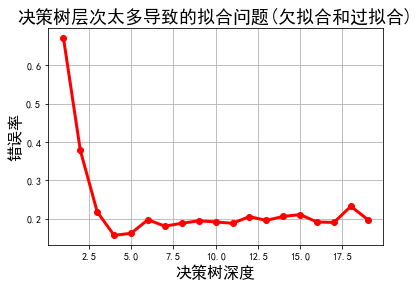

In [56]:
#查看各个不同深度的错误率
x_train4, x_test4, y_train4, y_test4 = x_train1, x_test1, y_train1, y_test1

depths = np.arange(1, 20)
err_list = []
for d in depths:
    clf = DecisionTreeRegressor(criterion='mse', max_depth=d)
    clf.fit(x_train4, y_train4)
    
    score1 = clf.score(x_test4, y_test4)
    err = 1 - score1
    err_list.append(err)
    print ("%d深度，正确率%.5f" % (d, score1))

## 画图
plt.figure(facecolor='w')
plt.plot(depths, err_list, 'ro-', lw=3)
plt.xlabel(u'决策树深度', fontsize=16)
plt.ylabel(u'错误率', fontsize=16)
plt.grid(True)
plt.title(u'决策树层次太多导致的拟合问题(欠拟合和过拟合)', fontsize=18)
plt.show()